## Libraries

In [36]:
import pandas as pd
import numpy as np

## Read the File:

In [37]:
data = pd.read_csv("C:/Users/ACER/OneDrive/Documentos/Analitica de datos/1. Maestria/2. Electiva II Mlops/Mlops/projetct_02/data/train.csv")
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## DATA CLEANNING

In [38]:
# Check for missing values in the dataset
missing_values = data.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64


In [39]:
import matplotlib.pyplot as plt

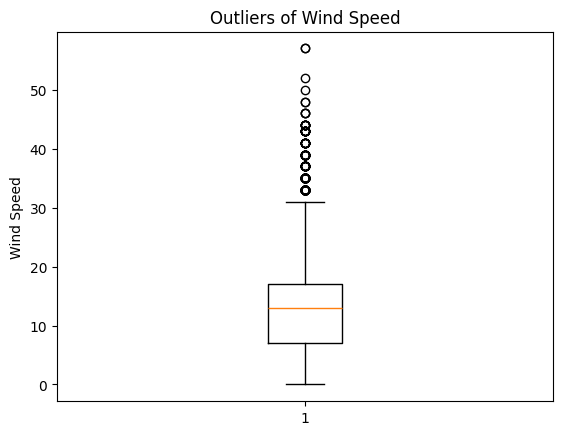

In [40]:
# Boxplot of the target variable 'wind_speed'
plt.boxplot(data['windspeed'])
plt.title('Outliers of Wind Speed')
plt.ylabel('Wind Speed')
plt.show()

In [41]:
## REMOVE ROWS WITH NEGATIVE OR ERRONEOUS VALUES:
data = data[data['windspeed'] >= 0]

In [42]:
## CANVERT "DATETIME" TO DATETIME OBJECTS:
data['datetime'] = pd.to_datetime(data['datetime'])

In [43]:
data['hour'] = data['datetime'].dt.hour
data['day_of_week'] = data['datetime'].dt.dayofweek
data['month'] = data['datetime'].dt.month

In [44]:
## CREATE BINARY WEaTHER VARIABLES:
data['is_clear_weather'] = (data['weather'] == 1).astype(int)
data['is_rainy_weather'] = (data['weather'] >= 3).astype(int)

In [45]:
## CREATE A COMBINED FEATURE FOR HOLIDAYS AND WORKING DAYS:
data['is_holiday'] = ((data['holiday'] == 1) & (data['workingday'] == 0))

In [46]:
## DROP IRRELEVANT COLUMNS:
data.drop(columns = ['datetime'], inplace=True)

## TRAINING AND TESTING SPLIT:

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
## SPLIT THE DATA INTO FEATURES AND TARGET VARIABLE:
X = data.drop(columns=['count']) # Features (all columns except 'count')
y = data['count'] # Target variable (the 'count' column)

In [16]:
## PERFORM AN 80-20 TRAIN TEST SPLIT:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## CHECK THE SHAPE OF THE TRAINING AND TEST SETS:
print(f"training data size: {X_train.shape}")
print(f"test data size: {X_test.shape}")

training data size: (8708, 16)
test data size: (2178, 16)


## MODEL CHOISE:

In [17]:
!pip install mlflow

In [18]:
import mlflow
import mlflow.sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

2025/04/28 20:23:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model training complete. MAE: 3.6302968771364386, RMSE: 6.941858434741431
Model logged to MLflow.


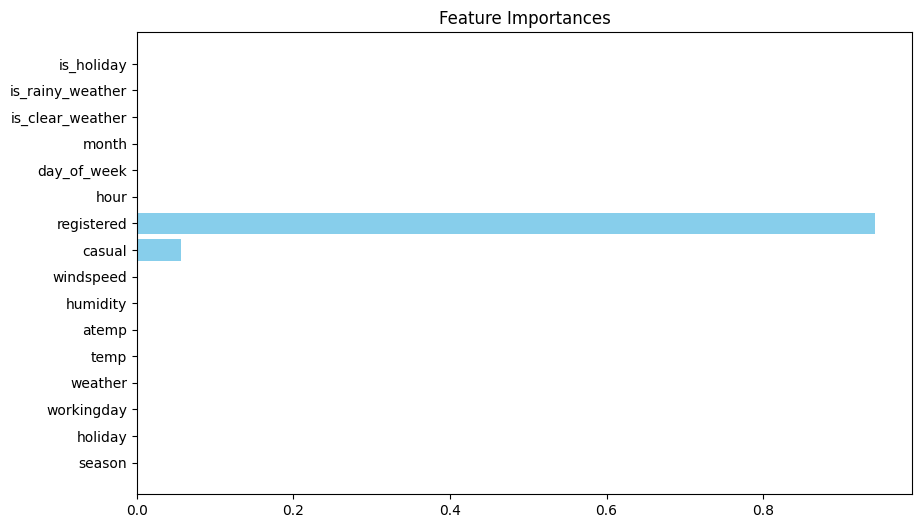

In [19]:
## DEFINE THE MODEL:
model = DecisionTreeRegressor(max_depth=10, random_state=42)

## STAR AN MLFLOW RUN:
with mlflow.start_run():
    # LOG PARAMS:
    mlflow.log_param("model_type", "DecisionTreeRegressor")
    mlflow.log_param("max_depth", 10)

    # TRAIN THE MODEL:
    model.fit(X_train, y_train)

    # MAKE PREDICTIONS:
    y_pred = model.predict(X_test)

    # CALCULATE METRICS:
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    #LOG METRICS EVALUATION:
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("rmse", rmse)

## PLOT AND LOG FEATURE IMPORTANCE AS AN ARTIFACT:

    feature_importances = model.feature_importances_
    feature_names = X_train.columns

    plt.figure(figsize=(10, 6))
    plt.barh(X_train.columns, feature_importances, color='skyblue')
    plt.title('Feature Importances')
    plt.savefig("feature_importances.png")

## LOG THE PLOT AS AN ARTIFACT:
    mlflow.log_artifact("feature_importances.png")

    # LOG THE MODEL itself:
    mlflow.sklearn.log_model(model, "model")

print(f"Model training complete. MAE: {mae}, RMSE: {rmse}")
print("Model logged to MLflow.")
# END OF THE SCRIPT

## MLflow for hyperparameter tuning

In [34]:
## LIBRERIAS:
import mlflow
import mlflow.sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [35]:

# Define the model and the hyperparameter grid
model = DecisionTreeRegressor(random_state=42)
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 10, 20]
}
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
# Start an MLFlow run for hyperparameter tuning
with mlflow.start_run():
    # Perform grid search
    grid_search.fit(X_train, y_train)

    # Log the best hyperparameters
    best_params = grid_search.best_params_
    mlflow.log_param("best_max_depth", best_params['max_depth'])
    mlflow.log_param("best_min_samples_split", best_params['min_samples_split'])

    # Log the best score (cross-validated)
    best_score = -grid_search.best_score_  # Convert to positive since we used neg_mean_squared_error
    mlflow.log_metric("best_cross_val_score", best_score)

    # Log the final model
    best_model = grid_search.best_estimator_
    mlflow.sklearn.log_model(best_model, "best_model")

    # Evaluate the model on the test set and log the result
    test_predictions = best_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    mlflow.log_metric("test_RMSE", test_rmse)

print(f"Best Hyperparameters: {best_params}")
print(f"Test RMSE: {test_rmse}")

Exception: Run with UUID 2b84e51245e448f9b8f9cee3fb99d3c1 is already active. To start a new run, first end the current run with mlflow.end_run(). To start a nested run, call start_run with nested=True

## Breaking Down the Code

In [25]:
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 10, 20]
}

## MLFlow Experiment Tracking:

In [28]:
mlflow.log_param("param_grid", str(param_grid))
mlflow.log_param("model_type", "DecisionTreeRegressor")

'DecisionTreeRegressor'

## Model Logging and Evaluation:

In [32]:
mlflow.sklearn.log_model(best_model, "best_model")
mlflow.log_metric("test_RMSE", test_rmse)

NameError: name 'best_model' is not defined